In [1]:
import pulp
from fractions import Fraction
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 1. Создание модели
# LpMaximize, так как мы максимизируем прибыль
model = pulp.LpProblem("Dog_Feed_Production_Optimization", pulp.LpMaximize)

# 2. Определение переменных решения
# lowBound=0 устанавливает ограничение неотрицательности x >= 0
x_R = pulp.LpVariable("Regular_kg", lowBound=0, cat='Continuous')
x_E = pulp.LpVariable("Extra_kg", lowBound=0, cat='Continuous')
x_P = pulp.LpVariable("Puppy_Delite_kg", lowBound=0, cat='Continuous')

# 3. Добавление целевой функции в модель
model += 20 * x_R + 18 * x_E + 25 * x_P, "Total_Profit"

# 4. Добавление ограничений в модель
model += (1/3) * x_R + 0.50 * x_E + 0.00 * x_P <= 1900, "Ingredient_A_Constraint"
model += (1/3) * x_R + 0.25 * x_E + 0.10 * x_P <= 1100, "Ingredient_B_Constraint"
model += (1/3) * x_R + 0.25 * x_E + 0.90 * x_P <= 1000, "Ingredient_C_Constraint"

# Вывод модели для проверки
print("Математическая модель:")
print(model)

# 5. Решение модели
model.solve()

# 6. Вывод статуса решения
print("\nСтатус решения:", pulp.LpStatus[model.status])

Математическая модель:
Dog_Feed_Production_Optimization:
MAXIMIZE
18*Extra_kg + 25*Puppy_Delite_kg + 20*Regular_kg + 0
SUBJECT TO
Ingredient_A_Constraint: 0.5 Extra_kg + 0.333333333333 Regular_kg <= 1900

Ingredient_B_Constraint: 0.25 Extra_kg + 0.1 Puppy_Delite_kg
 + 0.333333333333 Regular_kg <= 1100

Ingredient_C_Constraint: 0.25 Extra_kg + 0.9 Puppy_Delite_kg
 + 0.333333333333 Regular_kg <= 1000

VARIABLES
Extra_kg Continuous
Puppy_Delite_kg Continuous
Regular_kg Continuous


Статус решения: Optimal



--- Оптимальный производственный план ---
Производить Extra_kg: 3600.00 кг
Производить Puppy_Delite_kg: 0.00 кг
Производить Regular_kg: 300.00 кг

Максимальная прибыль составит: 70800.00 руб.


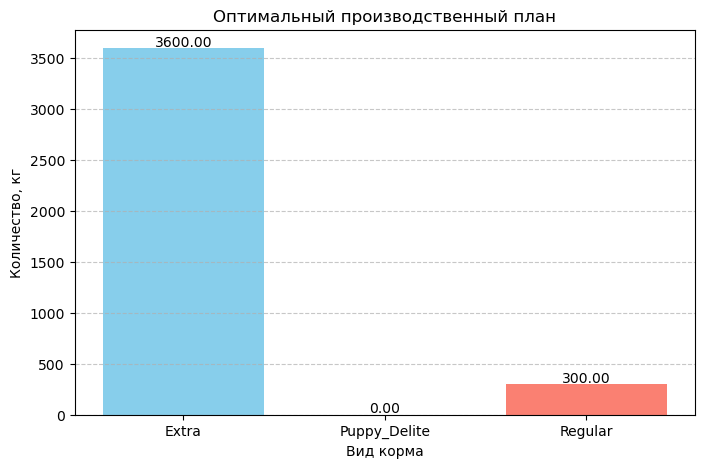

In [3]:
# Вывод результатов
print("\n--- Оптимальный производственный план ---")
if pulp.LpStatus[model.status] == 'Optimal':
    for var in model.variables():
        print(f"Производить {var.name}: {var.varValue:.2f} кг")
    
    print(f"\nМаксимальная прибыль составит: {pulp.value(model.objective):.2f} руб.")
    
    # Визуализация результатов
    plan_values = [var.varValue for var in model.variables()]
    plan_names = [var.name.replace('_kg', '') for var in model.variables()]
    
    plt.figure(figsize=(8, 5))
    plt.bar(plan_names, plan_values, color=['skyblue', 'lightgreen', 'salmon'])
    plt.title('Оптимальный производственный план')
    plt.ylabel('Количество, кг')
    plt.xlabel('Вид корма')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for index, value in enumerate(plan_values):
        plt.text(index, value + 20, f'{value:.2f}', ha='center')
    plt.show()

else:
    print("Оптимальное решение не найдено.")

In [4]:
print("\n--- Анализ рентабельности производства (Приведенные стоимости) ---")
print("Приведенная стоимость показывает, на сколько нужно увеличить прибыль от корма, чтобы он вошел в план.\n")

for var in model.variables():
    # var.dj - это и есть приведенная стоимость (reduced cost)
    print(f"Корм: {var.name}, Приведенная стоимость: {var.dj:.2f}")

print("\nАнализ:")
if x_R.varValue == 0 and x_R.dj < 0:
    print(f"Корм 'Regular' не выгодно производить. Чтобы он вошел в оптимальный план,")
    print(f"его прибыль необходимо увеличить как минимум на {-x_R.dj:.2f} руб./кг (с 20 до {20 - x_R.dj:.2f} руб./кг).")
else:
    print("Все корма, которые выгодно производить, уже включены в план.")


--- Анализ рентабельности производства (Приведенные стоимости) ---
Приведенная стоимость показывает, на сколько нужно увеличить прибыль от корма, чтобы он вошел в план.

Корм: Extra_kg, Приведенная стоимость: -0.00
Корм: Puppy_Delite_kg, Приведенная стоимость: -18.20
Корм: Regular_kg, Приведенная стоимость: -0.00

Анализ:
Все корма, которые выгодно производить, уже включены в план.


In [5]:
print("\n--- Анализ закупки дополнительных ингредиентов (Теневые цены) ---")
print("Теневая цена показывает, на сколько вырастет общая прибыль при добавлении 1 кг ингредиента.\n")

# Собираем данные для вывода
sensitivity_data = []
for name, constr in model.constraints.items():
    # constr.pi - это и есть теневая цена (shadow price)
    sensitivity_data.append({
        "Ограничение": name,
        "Теневая цена (руб./кг)": constr.pi,
        "Расход": constr.value() - constr.constant, # Фактический расход - Запас
        "Запас": -constr.constant
    })

df = pd.DataFrame(sensitivity_data)
print(df.to_string(index=False))

# Находим ингредиент с максимальной теневой ценой
max_shadow_price_row = df.loc[df['Теневая цена (руб./кг)'].idxmax()]
best_ingredient_name = max_shadow_price_row['Ограничение'].split('_')[1]
max_shadow_price = max_shadow_price_row['Теневая цена (руб./кг)']

print("\nАнализ:")
print(f"Наибольшую теневую цену имеет {max_shadow_price_row['Ограничение']} ({max_shadow_price:.2f} руб./кг).")
print("Это означает, что каждый дополнительный килограмм этого ингредиента принесет наибольший прирост прибыли.")
print(f"\nСледовательно, следует предпочесть закупку ингредиента '{best_ingredient_name}'.")

additional_kg = 80
profit_increase = max_shadow_price * additional_kg
print(f"При закупке {additional_kg} кг ингредиента '{best_ingredient_name}' прибыль увеличится на: {max_shadow_price:.2f} * {additional_kg} = {profit_increase:.2f} руб.")


--- Анализ закупки дополнительных ингредиентов (Теневые цены) ---
Теневая цена показывает, на сколько вырастет общая прибыль при добавлении 1 кг ингредиента.

            Ограничение  Теневая цена (руб./кг)  Расход  Запас
Ingredient_A_Constraint                    12.0  1900.0 1900.0
Ingredient_B_Constraint                    -0.0  1000.0 1100.0
Ingredient_C_Constraint                    48.0  1000.0 1000.0

Анализ:
Наибольшую теневую цену имеет Ingredient_C_Constraint (48.00 руб./кг).
Это означает, что каждый дополнительный килограмм этого ингредиента принесет наибольший прирост прибыли.

Следовательно, следует предпочесть закупку ингредиента 'C'.
При закупке 80 кг ингредиента 'C' прибыль увеличится на: 48.00 * 80 = 3840.00 руб.




#### 1. Ответ на Задание 2: Рентабельность производства

**Вопрос:** Все ли модели устройств выгодно производить? Если имеется убыточная модель, то что следует изменить, чтобы ее производство стало выгодным?

Смотрим на таблицу **"Ячейки переменных"** и столбец **"Приведенная Стоимость"**.

| Корм | Окончательное Значение | Приведенная Стоимость | Примечание |
| :--- | :--- | :--- | :--- |
| Regular | 300 кг | 0 | Входит в план, рентабелен. |
| Extra | 3600 кг | 0 | Входит в план, рентабелен. |
| Puppy Delite | 0 кг | -18.2 | Не входит в план, нерентабелен. |

**Вывод:**
Корм **Puppy Delite (x_P)** не выгодно производить, так как его производство равно 0.
Его приведенная стоимость составляет **-18.2**. Это означает, что текущая прибыль от него (25 руб./кг) слишком низка. Чтобы этот корм стал выгоден и вошел в оптимальный план, его прибыль необходимо увеличить минимум на **18.2 руб./кг**.

*   Требуемая минимальная прибыль: $25 + 18.2 = 43.2$ руб./кг.

#### 2. Ответ на Задание 3: Дополнительные ингредиенты (80 кг)

**Вопрос:** Какой ингредиент следует предпочесть для закупки 80 кг, и на сколько увеличится прибыль?

Смотрим на таблицу **"Ограничения"** и столбец **"Тень Цена"**.

| Ингредиент | Запас (Правая Сторона) | Тень Цена (руб./кг) | Допустимое Увеличение |
| :--- | :--- | :--- | :--- |
| А | 1900 | 12 | 100 |
| В | 1100 | 0 | $1Е+30$ |
| С | 1000 | 48 | 100 |

1.  **Ингредиент B** имеет теневую цену 0. Это значит, что он находится в избытке (используется только 1000 кг при запасе 1100 кг), и его закупка не принесет дополнительной прибыли.
2.  **Ингредиенты A и C** являются дефицитными, так как их теневые цены положительны.
3.  **Ингредиент C** имеет наибольшую теневую цену (**48 руб./кг**). Это означает, что каждый дополнительный килограмм этого ингредиента принесет наибольший прирост прибыли.

**Выбор:** Следует закупить **Ингредиент C**.

**Прирост прибыли:** Мы планируем закупить 80 кг.
*Проверяем интервал устойчивости Ингредиента C:* Допустимое увеличение составляет 100 кг. Поскольку $80 \text{ кг} < 100 \text{ кг}$, теневая цена $\text{48 руб./кг}$ остается действительной.

$$\text{Прирост прибыли} = \text{Тень Цена} \times \text{Количество} = 48 \text{ руб./кг} \times 80 \text{ кг} = 3840 \text{ рублей}$$

**Вывод:** Следует предпочесть закупку **Ингредиента C**. Прибыль увеличится на **3840 рублей**.

#### 3. Ответ на Задание 4: Дополнительные ингредиенты (150 кг)

**Вопрос:** Можно ли ответить на аналогичный вопрос, если есть возможность установить 150 кг сверхурочно, используя только отчет об устойчивости?

Мы снова смотрим на Ингредиент C, который является самым выгодным.

*   Требуемое изменение: **+150 кг**.
*   Допустимое увеличение запаса Ингредиента C (из отчета): **100 кг**.

**Анализ:**
Поскольку требуемое увеличение (150 кг) **превышает** допустимый интервал устойчивости (100 кг), мы **не можем** использовать теневую цену 48 руб./кг для расчета всей дополнительной прибыли.

Если мы добавим 150 кг Ингредиента C, произойдет следующее:
1.  Первые 100 кг добавят: $100 \text{ кг} \times 48 \text{ руб./кг} = 4800$ рублей.
2.  После добавления 100 кг структура оптимального решения изменится (либо изменятся теневые цены других ресурсов, либо другой ингредиент станет ограничивающим фактором).
3.  Теневая цена Ингредиента C **упадет** (возможно, до нуля), или начнет действовать другая теневая цена.

**Ответ:**
**Нет, нельзя.** Ответ, полученный только из отчета об устойчивости, будет неточным, так как изменение в 150 кг выходит за пределы допустимого интервала (100 кг). Для получения точного значения прибыли необходимо **пересчитать задачу** в Excel, установив запас Ингредиента C равным $1000 \text{ кг} + 150 \text{ кг} = 1150 \text{ кг}$.

Ответы на контрольные вопросы
1. Привести обобщенную математическую модель однокритериальной задачи принятия решений.
Это "рецепт" любой задачи оптимизации. Он состоит из трех частей:
Переменные решения (X): То, что мы можем менять (например, сколько кг корма производить).
Целевая функция (F(X) → max/min): То, что мы хотим улучшить — максимизировать (прибыль) или минимизировать (затраты).
Ограничения (G(X) ≤ b): Правила и лимиты, которые нельзя нарушать (например, запасы ингредиентов на складе).
2. Для вашей модели указать основные элементы задачи принятия решений.
Множество альтернатив: Любой возможный план производства (например, 100 кг Regular, 500 кг Extra, 0 кг Puppy Delite).
Множество исходов: Суммарная прибыль, которую мы получим для каждой альтернативы.
Критерий оценки: Максимизация общей прибыли.
Система предпочтений ЛПР (Лица, Принимающего Решение): "Больше прибыли — лучше".
Почему это задача в условиях определенности? Потому что все числа (прибыль, запасы, состав корма) известны заранее и не меняются.
3. Объяснить содержательный смысл переменных, целевой функции и ограничений в вашей модели.
Переменные: Это объемы производства каждого вида корма в килограммах (x_R, x_E, x_P).
Целевая функция: Это общая прибыль со всего произведенного корма, которую мы стремимся сделать максимальной.
Ограничения: Это лимиты по запасам ингредиентов (A, B, C). Мы не можем потратить ингредиентов больше, чем у нас есть на складе.
4. Объяснить различие между общей, стандартной и канонической формами моделей.
Это просто три разных способа записать одну и ту же задачу, удобные для разных математических методов.
Общая форма: "Свободный стиль", где ограничения могут быть любыми (≤, ≥, =).
Стандартная форма: Все ограничения — это строгие равенства (=).
Каноническая форма: Все ограничения — это неравенства (≤ для задачи максимизации). Именно в эту форму модель приводится для решения симплекс-методом.
5. Объяснить, что означает эквивалентность различных форм и привести правила преобразования.
Эквивалентность означает, что мы можем переписать задачу из одной формы в другую, и при этом оптимальное решение не изменится.
Правила преобразования:
Чтобы превратить ≤ в =, добавляют "остаточную" переменную (например, неиспользованный запас ингредиента).
Ограничение-равенство a = b можно заменить двумя неравенствами: a ≤ b и a ≥ b.
6. Привести и пояснить пример геометрического представления линейной модели для двух переменных.
Представьте график, где оси — это количество двух продуктов (например, корм Regular и Extra).
Каждое ограничение — это прямая линия, которая отсекает "запретную" область.
Область допустимых решений (ОДР) — это многоугольник, образованный этими линиями. Любая точка внутри него — это допустимый план производства.
Целевая функция — это тоже линия (линия уровня прибыли).
Решение задачи — это перемещение линии прибыли как можно дальше (при максимизации), пока она не коснется самой дальней вершины многоугольника ОДР. Оптимальное решение всегда находится в одной из вершин.
7. С какой целью выполняется анализ устойчивости? На какие вопросы он позволяет отвечать?
Цель: Понять, насколько "прочным" является найденное оптимальное решение.
Отвечает на "что, если" вопросы:
"Что, если прибыль от корма Extra упадет на 1 рубль? План производства изменится?"
"Что, если нам предложат купить еще 50 кг ингредиента C? Выгодно ли это?"
"Какой из наших ресурсов самый дефицитный?"
Анализ устойчивости позволяет отвечать на эти вопросы без полного пересчета всей задачи.
8. Какая информация содержится в отчете об устойчивости Excel?
Отчет состоит из двух таблиц:
Таблица по переменным: Показывает, какие продукты выгодно производить, а какие нет ("Приведенная стоимость"), и на сколько можно изменить их прибыльность, чтобы план не поменялся ("Допустимое увеличение/уменьшение").
Таблица по ограничениям: Показывает, какие ресурсы израсходованы полностью (дефицитные), а какие — нет. И самое главное — "Тень цена", которая говорит, на сколько вырастет общая прибыль, если добавить одну единицу дефицитного ресурса.
9. Что характеризуют интервалы устойчивости целевых коэффициентов и правых частей ограничений?
Интервал для целевого коэффициента (прибыли): Это диапазон цен для одного продукта, в котором состав оптимального плана не меняется (мы производим тот же набор кормов). Сама общая прибыль будет меняться, но решение "что производить" останется тем же.
Интервал для правой части (запаса ресурса): Это диапазон, в котором "Тень цена" этого ресурса остается постоянной. Если мы добавим ресурса больше, чем "допустимое увеличение", его ценность (тень цена) упадет.
10. Каким образом связаны между собой параметры прямой и двойственной задач?
Прямая и двойственная задачи — это две стороны одной медали.
Прямая задача (ваша): Максимизировать прибыль от производства, имея ограниченные ресурсы.
Двойственная задача (взгляд со стороны): Минимизировать общую "ценность" всех ресурсов, необходимых для производства.
Связь: Переменные двойственной задачи — это теневые цены ограничений прямой задачи.
11. Как связаны между собой оптимальные решения прямой и двойственной задач?
Очень просто:
Если у одной задачи есть оптимальное решение, то и у второй оно есть.
Теорема двойственности: Максимальная прибыль в прямой задаче в точности равна минимальной ценности ресурсов в двойственной задаче. Max(Прибыль) = Min(Ценность ресурсов).
12. Дать содержательную интерпретацию решения двойственной задачи. Что характеризуют теневые цены ресурсов?
Решение двойственной задачи — это определение "справедливой" внутренней ценности каждого вашего ресурса (ингредиента).
Теневая цена — это максимальная сумма, которую вы готовы заплатить за дополнительную единицу дефицитного ресурса.
В вашей задаче теневая цена ингредиента C была 48. Это значит, что каждый дополнительный килограмм этого ингредиента принесет вам 48 рублей дополнительной прибыли. Если вам предложат купить его по цене ниже 48 рублей, это будет выгодно.
Теневая цена ингредиента B была 0. Это значит, что у вас его в избытке, и дополнительный килограмм не принесет никакой прибыли. Его ценность для производства равна нулю.